In [1]:
import ee 
ee.Initialize()
import itertools
import geemap
import numpy as np
from sampling_handler.sampling import sample_size
from sampling_handler.misc import py_helpers
import pandas as pd
import seaborn as sns
from scipy import stats
from matplotlib import pyplot as plt
from retrying import retry

In [32]:
def plot_loss(loss_df, start, end):
    from matplotlib.lines import Line2D
    
    #sns.set(style="darkgrid")
    sns.set(style="white")
    fig, ax = plt.subplots(figsize=(12.5,7.5))

    ax = sns.barplot(loss_df, x='year', y='deforest', color='darkgrey', ax=ax)
    for g in ax.patches:
        ax.annotate(
            format(g.get_height(), '.1f'),
            (g.get_x() +g.get_width()/2, g.get_y() + g.get_height()),
            ha='center', 
            va='center',
            xytext=(0, 16),
            textcoords='offset points'
        )


    new_df = loss_df.copy()
    new_df.loc[(new_df.year<start) | (new_df.year>end), 'deforest'] = 0
    ax = sns.barplot(new_df, x='year', y='deforest', color='orange', ax=ax)
    ax.set_xlabel('Year') 
    ax.set_ylabel('Annual deforestation (km\u00B2)') 
    ax.set_title('Annual deforestation rates according to GFC')
    
    # a custom legend for a custom plot
    legend_elements = [
        Line2D([0], [0], color='orange', label='Selected Period'),
        Line2D([0], [0], color='darkgrey', label='Other years')
    ]
    
    ax.legend(handles=legend_elements)
    ax = sns.despine(offset=10, trim=True, ax=ax)

    return fig

In [33]:
def get_area_statistics(aoi, start, end, tree_cover=20, scale=70):
    
    if not isinstance(aoi, ee.FeatureCollection): 
        aoi = py_helpers.read_any_aoi_to_single_row_gdf(aoi)
        # and uplaod as FC to EE
        aoi = geemap.geopandas_to_ee(aoi)

    # load hansen image
    hansen = ee.Image("UMD/hansen/global_forest_change_2021_v1_9")
    forest_mask = hansen.select('treecover2000').gt(tree_cover).rename('forest_area')
    
    # rescale the right way, if scale is different from original
    if scale > 30:
        forest_mask = forest_mask.reduceResolution(**{
            "reducer": ee.Reducer.mean(), 
          "maxPixels": 65536
        }).reproject(
          forest_mask.projection().atScale(scale)
        ).gt(0.5).rename('forest_area')
    
    # create a pixel area image for area of full aoi
    aoi_area = (
        ee.Image(1).reproject(forest_mask.projection().atScale(scale)).rename('aoi_area')
    )
    
    # get actual forest area
    layer = forest_mask.addBands(aoi_area)
    forest_area_2000 = layer.multiply(ee.Image.pixelArea()).reduceRegion(**{
            "reducer": ee.Reducer.sum(),
            "geometry": aoi,
            "scale": scale,
            "maxPixels": 1e14,
    }).select(['forest_area', 'aoi_area']).getInfo()

    
    def yearly_loss(aoi, year):

        # create change layer for start and end date (inclusive)
        loss = hansen.select("lossyear").unmask(0)
        # get the mask right (weird decimal values in mask)
        loss = loss.updateMask(loss.mask().eq(1))
        # get loss of the year and apply forest mask
        loss = loss.eq(ee.Number(year).subtract(2000)).updateMask(forest_mask).unmask(0)

        # rescale the right way, if scale is different from original
        if scale > 30:
            loss = loss.reduceResolution(**{
                "reducer": ee.Reducer.mean(), 
              "maxPixels": 65536
            }).reproject(
              loss.projection().atScale(scale)
            ).gt(0.5)


        # get area 
        loss_area = loss.multiply(ee.Image.pixelArea()).reduceRegion(**{
            "reducer": ee.Reducer.sum(),
            "geometry": aoi,
            "scale": scale,
            "maxPixels": 1e14,
        }).select(['lossyear'])

        return [year, np.round(loss_area.getInfo()['lossyear']/1000000, 2)]
    

    gfc_args = []
    for year in range (2001, 2022, 1):
        gfc_args.append([aoi, year])
    
    results = py_helpers.run_in_parallel(yearly_loss, gfc_args, 15)
    
    # aggreagte to dataframe
    loss_df = pd.DataFrame(results)
    loss_df.columns = ['year', 'deforest']
    loss_df.sort_values('year', inplace=True)

    deforest_before_start = loss_df.deforest[loss_df.year < start].sum()
    deforest_period = loss_df.deforest[(loss_df.year >= start) & (loss_df.year <= end)].sum()
    forest_area = np.round(forest_area_2000['forest_area']/1000000, 2) - deforest_before_start
    
    area_dict = {
        'total_area': np.round(forest_area_2000['aoi_area']/1000000, 2),
        'forest_area': forest_area, 
        'change_area': deforest_period
    }
    figure = plot_loss(loss_df, start, end)
    return area_dict, loss_df, figure

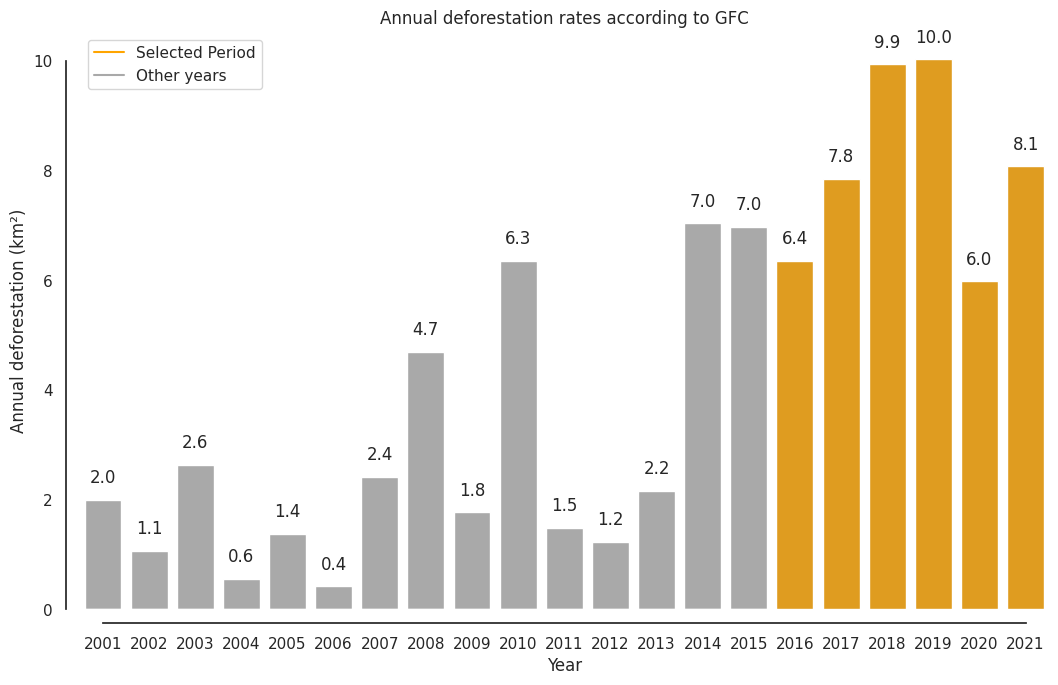

In [34]:
# period of change
start_year = 2016
end_year = 2021

# forest definition
tree_cover = 30         # in percent
mmu = 0.5               # in hectare (not yet implemented)
mmu = 100
# aoi (various options, e.g. shapefile, geodataframe, ee FeatureCollection)
# based on earth engine feature collection
country = 'Burundi'
gaul = ee.FeatureCollection("FAO/GAUL/2015/level1")
aoi = gaul.filter(ee.Filter.eq("ADM0_NAME", country)).union()

adict, loss_df, figure = get_area_statistics(aoi, start_year, end_year, tree_cover, scale=mmu)

In [31]:
figure.savefig

In [ ]:
target_error = 0.1  # fraction 0-1
conf_interval = 0.95 

calculated_df, selected_spacing = sample_size.determine_minimum_sample_size(adict, target_error, conf_interval)
sample_size.display_minimum_sample_size(calculated_df, selected_spacing)

In [6]:
adict

{'total_area': 1129313.5, 'forest_area': 117301.05, 'change_area': 1373.02}

In [7]:
def add_statistical_measures(row, actual_change, confidence_level=0.95):
    """
    Calculates bias and uncertainty for a given row of sampled data and actual
    change value.

    Args:
        row: A pandas DataFrame row containing the sampled change data.
        actual_change: A float representing the actual change value for the
                       area of interest.
        confidence_level: A float specifying the desired confidence level
                          as a percentage. Default is 0.95.

    Returns:
        A tuple containing the mean deviation, standard deviation of deviation,
        mean area, standard deviation of area, and uncertainty.
    """

    # bias calculation
    abs_errors = [
        np.abs(np.subtract(i, actual_change)) for i in row['sampled_change']
    ]
    mean_dev, sd_dev = np.nanmean(abs_errors), np.nanstd(abs_errors)

    # uncertainty calculation
    mean_area = np.nanmean(row['sampled_change'])
    sd_area = np.nanstd(row['sampled_change'])
    z_score = abs(stats.norm.ppf((1 - confidence_level) / 2))
    ci = z_score * sd_area
    uncertainty = ci / mean_area * 100

    return mean_dev, sd_dev, mean_area, sd_area, uncertainty

In [8]:
#@retry(stop_max_attempt_number=5, wait_random_min=5000, wait_random_max=15000)
def gfc_sampling_simulation(
        aoi,
        start,
        end,
        area_dict,
        nr_of_runs_per_grid,
        grid_spacings,
        random_seed,
        scale=30,
        confidence_level=0.95
):
    
    if not isinstance(scale, list):
        scale = [scale]
        
    # create random seeds
    np.random.seed(random_seed)
    seeds = np.random.random(nr_of_runs_per_grid)
    seeds = list(np.round(np.multiply(seeds, 100), 0))

    # get lossyear
    loss = ee.Image(
        'UMD/hansen/global_forest_change_2021_v1_9'
    ).select('lossyear').unmask(0)

    # filter for time of interest
    loss = loss.gte(ee.Number(start).subtract(2000)).And(
        loss.lte(ee.Number(end).subtract(2000)))

    
    # -----------------------------------------------------------------
    # nested function for getting proportional change per grid size
    @retry(stop_max_attempt_number=3, wait_random_min=5000, wait_random_max=15000)
    def sample_simulation(grid_spacing, scale, loss):
        
        # re-scale
        if scale != 30:
            loss = loss.reduceResolution(**{
                "reducer": ee.Reducer.mean(), 
                "maxPixels": 65536
            }).reproject(
                loss.projection().atScale(scale)
            ).gt(0.5)
        
        # set grid spacing as forced pixel size
        proj_at_spacing = loss.projection().atScale(grid_spacing)

        # get overall sample size
        overall_sample_size = ee.Image(1).rename('sample_size').reproject(
            proj_at_spacing
        ).reduceRegion(**{
                'reducer': ee.Reducer.sum(),
                'geometry': aoi,
                'scale': grid_spacing,
                'maxPixels': 1e14
            }).get('sample_size')

        # -----------------------------------------------------------------
        # nested function for getting proportional change per seed and grid
        @retry(stop_max_attempt_number=3, wait_random_min=5000, wait_random_max=15000)
        def sample_change(seed, proj):

            # create a subsample of our change image
            cells = ee.Image.random(seed).multiply(1000000).int().reproject(proj)
            random = ee.Image.random(seed).multiply(1000000).int()
            maximum = cells.addBands(random).reduceConnectedComponents(ee.Reducer.max())
            points = random.eq(maximum).selfMask().reproject(proj.atScale(scale))

            # create a stack with change and total pixels as 1
            stack = (
                loss.updateMask(points)  # masked sample change
                .addBands(points)  # all samples
                .multiply(
                    ee.Image.pixelArea()
                ).rename(['sampled_change', 'sampled_area'])
            )

            # sum them up
            areas = stack.reduceRegion(**{
                'reducer': ee.Reducer.sum(),
                'geometry': aoi,
                'scale': scale,
                'maxPixels': 1e14
            })

            # calculate proportional change to entire sampled area
            proportional_change_sampled = ee.Number(
                areas.get('sampled_change')).divide(
                ee.Number(areas.get('sampled_area'))).getInfo()

            return proportional_change_sampled

        # -----------------------------------------------------------------
        # get sample error mean and stddev
        proportional_changes = [
            sample_change(seed, proj_at_spacing) for seed in seeds
        ]

        # add to a dict of all grids
        return proportional_changes, overall_sample_size.getInfo(), grid_spacing, scale

    d, dfs = {}, []
    # we map over all different grid sizes
    print(" Running the sampling error simulation. "
          "Please be patient, this can take a while.")
    
    # create list of args for parallel execution
    args = []
    for arguments in itertools.product(grid_spacings, scale):
        base_args = list(arguments)
        base_args.append(loss)
        args.append(base_args)
    
    # extract in parallel
    results = py_helpers.run_in_parallel(sample_simulation, args, 15)
    
    # turn to dataframe
    stats_df = pd.DataFrame(results)
    stats_df.columns = ['sampled_change', 'sample_size', 'spacing', 'scale']
    
    # get actual change
    actual_change = area_dict['change_area']/area_dict['total_area']
    
    # add bias and uncertainty calculations
    stats_df[[
        'mean_bias', 'sd_bias', 'mean_sampled_area', 'sd_sampled_area', 'uncertainty'
    ]] = stats_df.apply(
        lambda x: add_statistical_measures(x, actual_change, confidence_level),
        axis=1,
        result_type='expand'
    )

    return stats_df

In [9]:
%%time
r = gfc_sampling_simulation(
        aoi, start_year,
        end_year,
        adict,
        25,
        [500, 1000, 2000, 4000], #, 4000, 10000], #, 5000, 10000], #, 4000, 8000],
        random_seed = 42,
        scale=[30, 70, 100], #, 100, 250],
        confidence_level=0.95
)

 Running the sampling error simulation. Please be patient, this can take a while.
CPU times: user 5.27 s, sys: 209 ms, total: 5.48 s
Wall time: 33min 16s


<Axes: xlabel='sample_size', ylabel='uncertainty'>

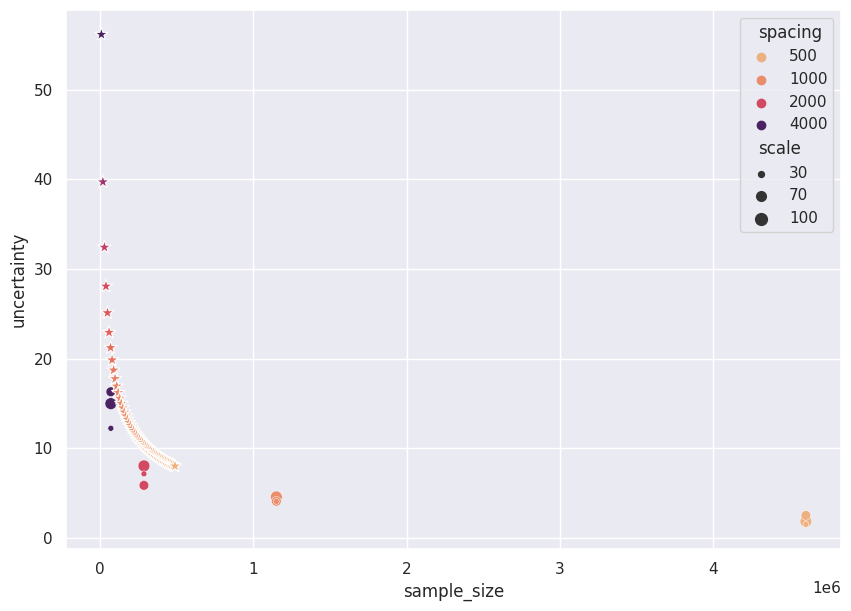

In [10]:
fig, ax = plt.subplots(figsize=(10,7))
palette = sns.color_palette("flare", as_cmap=True)
ax = sns.scatterplot(data=r, x='sample_size', y='uncertainty',  hue='spacing', size='scale', palette=palette)
sns.scatterplot(
    data=calculated_df, 
    x='Sample Size', 
    y='Margin of Error (Deforestation)',  
    hue='Grid Spacing', 
    marker='*', s=100, 
    legend=False,
    palette=palette
)

In [11]:
calculated_df

,Sample Size,Margin of Error (Forest),Margin of Error (Deforestation),Grid Spacing
0,10000,5.756918,56.176251,10.626916
1,20000,4.070756,39.722608,7.514365
2,30000,3.323758,32.433374,6.135453
3,40000,2.878459,28.088125,5.313458
4,50000,2.574572,25.122783,4.752501
5,60000,2.350252,22.933858,4.338420
6,70000,2.175911,21.232627,4.016597
7,80000,2.035378,19.861304,3.757182
8,90000,1.918973,18.725417,3.542305
9,100000,1.820497,17.764490,3.360526
